In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
import time
import seaborn as sns
from scipy import stats
import folium
import nltk
import string
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from folium.plugins import HeatMap
from math import radians, cos, sin, asin, sqrt
from sklearn.preprocessing import PowerTransformer
from statlearning import crosstabplots, plot_dists

In [2]:
tic = time.time()

warnings.filterwarnings("ignore")
sns.set_context('notebook')
sns.set_style('ticks')
crayon = ['#4E79A7', '#F28E2C', '#E15759', '#76B7B2', '#59A14F',
          '#EDC949', '#AF7AA1', '#FF9DA7', '#9C755F', '#BAB0AB']
sns.set_palette("pastel")
plt.rcParams['figure.figsize'] = (16, 9)
%matplotlib inline

In [3]:
df = pd.read_csv("train.csv")

In [4]:
df.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'notes', 'transit', 'access', 'interaction',
       'house_rules', 'host_id', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'city', 'zipcode', 'smart_location',
       'latitude', 'longitude', 'is_location_exact', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'square_feet', 'weekly_discount',
       'monthly_discount', 'security_deposit_perc', 'cleaning_fee_perc',
       'guests_included', 'extra_people_perc', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_

## Data Preprocessing

### Uesless columns

In [5]:
useless_cols = ["host_id","zipcode","last_review","first_review"]
df.drop(columns=useless_cols, inplace=True)

### Missing Values

In [6]:
df.isnull().sum()[:40]

name                            0
summary                         0
space                        2654
description                     0
experiences_offered             0
neighborhood_overview        3438
notes                        5538
transit                      3369
access                       3892
interaction                  3878
house_rules                  3987
host_since                      0
host_location                   8
host_about                   4363
host_response_time           4566
host_response_rate           4566
host_acceptance_rate         9838
host_is_superhost               0
host_neighbourhood           2915
host_listings_count             0
host_total_listings_count       0
host_verifications              0
host_identity_verified          0
street                          0
neighbourhood                1151
neighbourhood_cleansed          0
city                            6
smart_location                  0
latitude                        0
longitude     

In [7]:
df.isnull().sum()[40:]

weekly_discount                                 8940
monthly_discount                                9299
security_deposit_perc                           3303
cleaning_fee_perc                               2445
guests_included                                    0
extra_people_perc                                  0
minimum_nights                                     0
maximum_nights                                     0
minimum_minimum_nights                             0
maximum_minimum_nights                             0
minimum_maximum_nights                             0
maximum_maximum_nights                             0
minimum_nights_avg_ntm                             0
maximum_nights_avg_ntm                             0
availability_30                                    0
availability_60                                    0
availability_90                                    0
availability_365                                   0
number_of_reviews                             

#### Columns contains > 50% missing values

In [8]:
missing_values_cols = [df.columns[index]  for index in np.where(df.isnull().sum()>(len(df) * 0.5))[0]]
missing_values_cols

['notes',
 'host_acceptance_rate',
 'square_feet',
 'weekly_discount',
 'monthly_discount']

#### Columns contains (>10%) missing values

In [9]:
temp = [df.columns[index]  for index in np.where(df.isnull().sum()>(len(df) * 0.1))[0]]
missing_values_warning_cols = [x for x in temp if x not in missing_values_cols]
missing_values_warning_cols

['space',
 'neighborhood_overview',
 'transit',
 'access',
 'interaction',
 'house_rules',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_neighbourhood',
 'neighbourhood',
 'security_deposit_perc',
 'cleaning_fee_perc',
 'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
 'reviews_per_month']

#### precessing "host_response_rate"

In [10]:
df.host_response_rate = df.host_response_rate.str.replace("%","").astype(float)/100


#### Missing value columns Classification 

In [11]:
number_missing_avg_cols = ["host_response_rate","bathrooms","bedrooms","beds",'review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value',
                          ]

number_missing_zero_cols = ["security_deposit_perc","cleaning_fee_perc","reviews_per_month"]

string_missing_cols = ["host_response_time","host_location","host_neighbourhood","neighbourhood","city","cancellation_policy"
                  ]

text_missing_cols = ["space","neighborhood_overview","transit","access","interaction","house_rules",
                     "host_about",
                    ]

#### Missing Value precessing

In [12]:
df.drop(missing_values_cols, inplace=True, axis=1)

for col in text_missing_cols:
    df[col].fillna("", inplace=True)
for col in string_missing_cols:
    df[col].fillna("None", inplace=True)
for col in number_missing_avg_cols:
    mean_val = df[col].mean()
    df[col].fillna(mean_val, inplace=True)
for col in number_missing_zero_cols:
    df[col].fillna(0, inplace=True)

#### validation

In [13]:
df.isnull().sum()[:40]

name                         0
summary                      0
space                        0
description                  0
experiences_offered          0
neighborhood_overview        0
transit                      0
access                       0
interaction                  0
house_rules                  0
host_since                   0
host_location                0
host_about                   0
host_response_time           0
host_response_rate           0
host_is_superhost            0
host_neighbourhood           0
host_listings_count          0
host_total_listings_count    0
host_verifications           0
host_identity_verified       0
street                       0
neighbourhood                0
neighbourhood_cleansed       0
city                         0
smart_location               0
latitude                     0
longitude                    0
is_location_exact            0
property_type                0
room_type                    0
accommodates                 0
bathroom

In [14]:
df.isnull().sum()[40:]

extra_people_perc                               0
minimum_nights                                  0
maximum_nights                                  0
minimum_minimum_nights                          0
maximum_minimum_nights                          0
minimum_maximum_nights                          0
maximum_maximum_nights                          0
minimum_nights_avg_ntm                          0
maximum_nights_avg_ntm                          0
availability_30                                 0
availability_60                                 0
availability_90                                 0
availability_365                                0
number_of_reviews                               0
number_of_reviews_ltm                           0
review_scores_rating                            0
review_scores_accuracy                          0
review_scores_cleanliness                       0
review_scores_checkin                           0
review_scores_communication                     0


**Review_scored will be engineered later.**

### preprocessing

In [15]:
df.host_since= pd.DataFrame((pd.datetime.today() - pd.to_datetime(df["host_since"])).apply(lambda x: x.days).rename("host_days"))

df.price=df.price.str.replace('$','')
df.price=df.price.str.replace(',','').astype(float)

percent_cols = ["security_deposit_perc",
                "cleaning_fee_perc", "extra_people_perc"]

for col in percent_cols:
    df[col+"_money"] = pd.Series([df["price"][idx] * df[col][idx]/100  for idx in range(len(df))])

### Outlier

In [16]:
def subplot_box(df):
    """

    """

    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        sns.boxplot(x=df[col])
        
def plot_distributed(series):
    
    sns.distplot(series, fit=stats.norm, bins=10, color='cornflowerblue')
    (mu, sigma) = stats.norm.fit(series)
    plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=${:.2f})'.format(
        mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution of '+series.name)
    
def plot_outlier(series):
    plt.figure()
    plt.title(series.name)
    sns.boxplot(x=series)
    plt.figure()
    plt.hist(series)
    plt.figure()
    plot_distributed(series)
    
    
    
    
def zscore_drop_outlier(df, col_list, THRESHOLD=3):
    """
    
    """
    for col in col_list:
        z = np.abs(stats.zscore(df[col]))
        df = df[(z < THRESHOLD)]

    df.index = range(len(df))
    return df

#### Price preprocessing

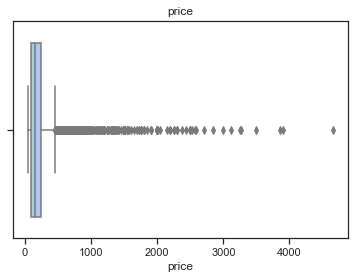

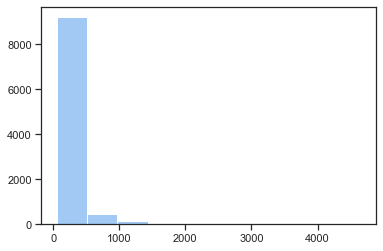

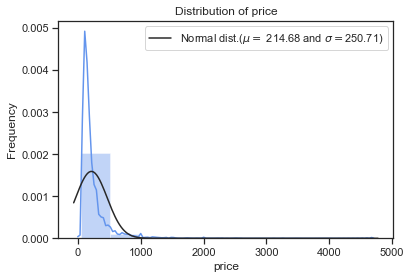

In [17]:
plot_outlier(df["price"])

In [18]:
len(df)

9838

In [19]:
len(zscore_drop_outlier(df, ["price"], THRESHOLD=3.5))

9694

Remove 144 rows

#### Remove price outlier

In [20]:
df = zscore_drop_outlier(df, ["price"], THRESHOLD=3.5)

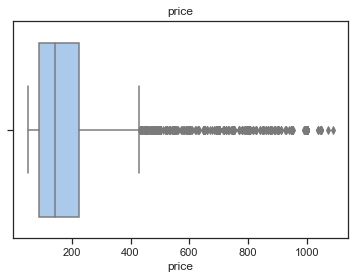

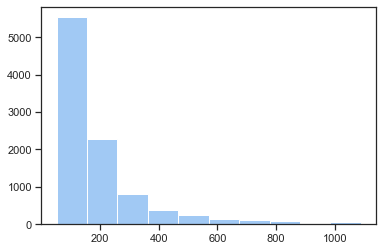

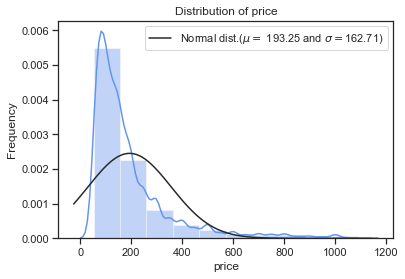

In [21]:
plot_outlier(df["price"])

## Exploratory data analysis (EDA)

### EDA functions

In [22]:
def subplot_box(df):
    """

    """

    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        sns.boxplot(x=df[col])
        
def get_status(x):
    return pd.DataFrame([x.count(), x.mean(),  x.min(), x.quantile(.25), x.quantile(.5), x.quantile(.75), x.max(), x.median(), x.mad(), x.var(), x.std(), x.skew(), x.kurt(), ],
                        index=['count', 'mean', 'min', '25%', '50%', '75%', 'max', 'median', 'mad', 'var', 'std', 'skew', 'kurt', ]).round(3)


def plot_distributed(series):
    
    sns.distplot(series, fit=stats.norm, bins=10, color='cornflowerblue')
    (mu, sigma) = stats.norm.fit(series)
    plt.legend(['Normal dist.($\mu=$ {:.2f} and $\sigma=${:.2f})'.format(
        mu, sigma)], loc='best')
    plt.ylabel('Frequency')
    plt.title('Distribution of '+series.name)

def subplot_distributed(df):
    """

    """
    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        plot_distributed(df[col])
        ax.set_title(col)

        
def subplot_hist(df):
    """

    """
    plt.figure(figsize=(30, 120))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        plt.title('Hist of '+ col)
        plt.hist(df[col])        
        
def plot_prob(series):
    stats.probplot(series,plot=plt)
    

def subplot_prob(df):
    """

    """
    plt.figure(figsize=(30, 90))
    num_subplot = len(df.columns)
    for i, col in enumerate(df.columns):
        ax = plt.subplot(num_subplot//2 + 1, 2, i+1)
        sns.set_palette("pastel")
        plot_prob(df[col])
        ax.set_title(col)
        
 

In [23]:
pd.crosstab(index=df["bed_type"], columns="count")

col_0,count
bed_type,
Airbed,4
Couch,1
Futon,12
Pull-out Sofa,29
Real Bed,9648


### Features Classification

In [24]:
df.columns

Index(['name', 'summary', 'space', 'description', 'experiences_offered',
       'neighborhood_overview', 'transit', 'access', 'interaction',
       'house_rules', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_is_superhost',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_identity_verified', 'street', 'neighbourhood',
       'neighbourhood_cleansed', 'city', 'smart_location', 'latitude',
       'longitude', 'is_location_exact', 'property_type', 'room_type',
       'accommodates', 'bathrooms', 'bedrooms', 'beds', 'bed_type',
       'amenities', 'security_deposit_perc', 'cleaning_fee_perc',
       'guests_included', 'extra_people_perc', 'minimum_nights',
       'maximum_nights', 'minimum_minimum_nights', 'maximum_minimum_nights',
       'minimum_maximum_nights', 'maximum_maximum_nights',
       'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_

In [25]:
# [val for val in numerical_cols if val in list(df.columns)]

In [26]:
location_cols = ["host_location", "host_neighbourhood", "street", "neighbourhood", "neighbourhood_cleansed",
                 "city", "smart_location", "latitude", "longitude"]

review_scores_cols = ["review_scores_rating", "review_scores_accuracy", "review_scores_cleanliness",
                      "review_scores_checkin", "review_scores_communication", "review_scores_location",
                      "review_scores_value"]

txt_cols = ['name', 'summary', 'space', 'description', 'neighborhood_overview', 'transit', 'access',
            'interaction', 'house_rules', "host_about", ]


set_cols = ["host_verifications", "amenities"]

category_cols = ["experiences_offered", "host_response_time", "is_location_exact",
                 'property_type', 'room_type', "cancellation_policy", "host_is_superhost",
                 "host_identity_verified", 'requires_license', 'instant_bookable', 'is_business_travel_ready',
                 'require_guest_profile_picture', 'require_guest_phone_verification',"bed_type"]


numerical_cols = ["host_response_rate", "host_listings_count", "host_total_listings_count", "accommodates",
                  'bathrooms', 'bedrooms', 'beds',
                  "bed_type", "guests_included", 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
                  'maximum_minimum_nights', 'minimum_maximum_nights', 'maximum_maximum_nights',
                  'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'availability_30', 'availability_60',
                  'availability_90', 'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
                  'calculated_host_listings_count', 'calculated_host_listings_count_entire_homes',
                  'calculated_host_listings_count_private_rooms',
                  'calculated_host_listings_count_shared_rooms', 'reviews_per_month', "host_since",
                  "security_deposit_perc","cleaning_fee_perc", "extra_people_perc", 
                  'security_deposit_perc_money', 'cleaning_fee_perc_money','extra_people_perc_money']

response = "price"

In [27]:
# len(location_cols) + len(review_scores_cols) + len(txt_cols) + \
#     len(set_cols) + len(category_cols) + len(percent_cols)+ len(numerical_cols)+ len(response)+len(time_cols)

### Special columns

#### txt columns

In [28]:
def process_text(txt_series, response_series):
    
    vectorizer = CountVectorizer(min_df=2, max_df=0.8, stop_words='english')
    stemmed = [PorterStemmer().stem(word) for word in txt_series]
    X = vectorizer.fit_transform(stemmed)
    
    tokens = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names())
    
    response_name = "airbnb_" + response_series.name
    tokens = pd.concat([tokens, response_series.rename(response_name)], axis=1)
    
    indice_10_token = np.argsort(
        abs(tokens.corr()[response_name].values))[::-1][1:11]
    col_list = [tokens.columns[index] for index in indice_10_token]
    edited_name = [txt_series.name + "_token_" + tokens.columns[index]
                   for index in indice_10_token]
    
    df_temp = tokens[col_list]
    df_temp.columns = edited_name
    
    return df_temp

def fe_text(df, set_cols, response):
    temp = pd.DataFrame()
    for col in set_cols:
        processed = process_text(df[col],df[response])
        temp = pd.concat([temp,processed],axis=1)
    return temp



def txt_eda(df, txt_cols, response):
    for col in txt_cols:
        eda_df = process_text(df[col], df[response])
        print(eda_df.head())
        print("The 10 most correlated tokens in " + col)
        response_name = "airbnb_" + response
        eda_df = pd.concat([eda_df, df[response].rename(response_name)], axis=1)

        print(abs(eda_df.corr()[response_name]).sort_values(ascending=False)[1:11])
        plt.figure()
        sns.heatmap(eda_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
        plt.title('Correlations among Top10 tokns in '+ col)
        plt.show()
    

所有 txt_col 的 eda
用的时间很长，先注释

   name_token_room  name_token_family  name_token_private  name_token_home  \
0                1                  0                   1                0   
1                0                  0                   0                0   
2                1                  0                   0                0   
3                1                  0                   0                0   
4                0                  0                   0                0   

   name_token_pros  name_token_beach  name_token_house  name_token_hous  \
0                0                 0                 0                0   
1                0                 0                 0                0   
2                0                 0                 0                0   
3                0                 0                 0                0   
4                0                 0                 0                0   

   name_token_pool  name_token_avalon  
0                0                  0  


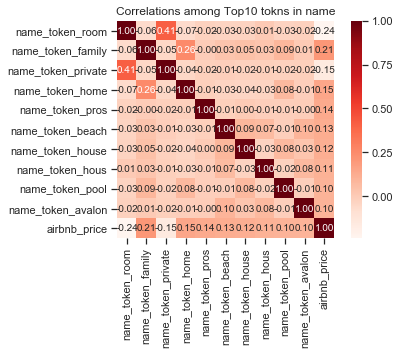

In [ ]:
txt_eda(df, txt_cols, response)

column ”Name“ eda

In [30]:
eda_df = process_text(df["name"], df["price"])

In [31]:
eda_df.head()

,name_token_room,name_token_family,name_token_private,name_token_home,name_token_pros,name_token_beach,name_token_house,name_token_hous,name_token_pool,name_token_avalon
0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


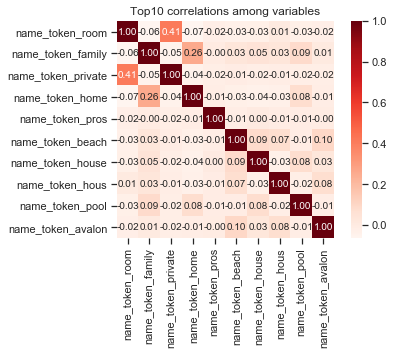

In [32]:
plt.figure()
sns.heatmap(eda_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Top10 correlations among variables')
plt.show()


The detail of the process_text function 

In [33]:
vectorizer = CountVectorizer(min_df=2, max_df=0.8, stop_words='english')

In [34]:
stemmed = [PorterStemmer().stem(word) for word in df['name']]
X = vectorizer.fit_transform(stemmed)

In [35]:
vectorizer.get_feature_names()

['01',
 '07',
 '10',
 '100',
 '100m',
 '109',
 '10km',
 '10min',
 '10mins',
 '11',
 '110',
 '12',
 '13',
 '14',
 '14th',
 '15',
 '150m',
 '15min',
 '15mins',
 '16',
 '17',
 '180',
 '1b',
 '1bd',
 '1bdr',
 '1bdrm',
 '1bed',
 '1bedroom',
 '1bhk',
 '1br',
 '1car',
 '1km',
 '1min',
 '1st',
 '20',
 '200',
 '200m',
 '2017',
 '2018',
 '2019',
 '20min',
 '22',
 '23',
 '25',
 '250m',
 '270',
 '28',
 '2b',
 '2ba',
 '2bath',
 '2bd',
 '2bdr',
 '2bed',
 '2bed1bath',
 '2bed2bath',
 '2bedroom',
 '2bedrooms',
 '2beds1bath',
 '2beds2bath',
 '2br',
 '2brm',
 '2bth',
 '2km',
 '2min',
 '2mins',
 '30',
 '300m',
 '3b',
 '3bd',
 '3bdr',
 '3bed',
 '3bedroom',
 '3br',
 '3km',
 '3min',
 '40',
 '41',
 '45',
 '4br',
 '4km',
 '4min',
 '50',
 '500',
 '500m',
 '50m',
 '57',
 '5br',
 '5km',
 '5min',
 '5mins',
 '600m',
 '64',
 '66',
 '6km',
 '70',
 '7th',
 '90',
 '99',
 'abod',
 'abode',
 'absolute',
 'absolutely',
 'ac',
 'access',
 'accessible',
 'accommod',
 'accommodation',
 'accomod',
 'accomodation',
 'acreag',


In [36]:
X.toarray().shape

(9694, 1583)

In [37]:
tokens = pd.DataFrame(X.toarray(),columns=vectorizer.get_feature_names())
tokens = pd.concat([tokens, df["price"].rename("airbnb_price")],axis = 1)

In [38]:
tokens.head()

,01,07,10,100,100m,109,10km,10min,10mins,11,...,完美的悉尼之旅,市中心,新房促销,步行达令港,舒适,近市区,近情人港,近火车站,靠近唐人街,airbnb_price
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,58.0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125.0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,99.0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,99.0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,125.0


In [39]:
abs(tokens.corr()["airbnb_price"]).sort_values(ascending=False)[:10]

airbnb_price    1.000000
room            0.239881
family          0.208726
private         0.154784
home            0.149236
pros            0.137264
beach           0.127967
house           0.121048
hous            0.105933
pool            0.102971
Name: airbnb_price, dtype: float64

In [40]:
indice = np.argsort(abs(tokens.corr()["airbnb_price"].values))[::-1][1:11]
col_list = [tokens.columns[index] for index in indice]
edited_name = ["name_token_" + tokens.columns[index] for index in indice]
df_temp = tokens[col_list]
df_temp.columns = edited_name

In [41]:
col_list = [tokens.columns[index] for index in indice]
edited_name = ["name_token_" + tokens.columns[index] for index in indice]

In [42]:
df_temp.head()

,name_token_room,name_token_family,name_token_private,name_token_home,name_token_pros,name_token_beach,name_token_house,name_token_hous,name_token_pool,name_token_avalon
0,1,0,1,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0
3,1,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0


#### location cols

In [43]:
def haversine(lon1, lat1, lon2, lat2): # 经度1，纬度1，经度2，纬度2 （十进制度数）
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # 将十进制度数转化为弧度
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
 
    # haversine公式
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # 地球平均半径，单位为公里
    return c * r

In [44]:
heatdata = [[df["latitude"][idx], df["longitude"][idx], df["price"][idx]]
            for idx in range(len(df))]

##### Draw a map of all house
The Latitude and longitude of Sydney Townhall is **-33.873098, 151.206093**

In [45]:
markers = {
    "Sydney_Townhall": [-33.873098, 151.206093],
    "Bondi_Beach":[-33.891505, 151.277058],
    "Opera_House":[-33.856717, 151.215308],
    "T1_airport":[-33.937614, 151.165978],
    "T2_airport":[-33.933588, 151.181066],
    "central_station":[-33.883048, 151.206970],
}

In [46]:
san_map = folium.Map(location=markers["Sydney_Townhall"], zoom_start=12)

for i,pos in enumerate(zip(df["latitude"], df["longitude"])):
    folium.CircleMarker(
        location=[pos[0], pos[1]],
        radius=1,
        fill=True,
        fill_color='red',
        fill_opacity=0.4
    ).add_to(san_map)
    
san_map.save('basemap.html')


##### Draw a heatmap of  house price

In [47]:
heat_map = folium.Map(location=markers["Sydney_Townhall"], zoom_start=12)
HeatMap(heatdata,
        radius=11,
        blur=25
       ).add_to(heat_map)
heat_map.save("heatmap.html")
heat_map

In [48]:
temp_df = pd.DataFrame()
for marker in list(markers.keys()):

    temp = [haversine(df["longitude"][idx], df["latitude"][idx], markers[marker][1], 
           markers[marker][0]) for idx in range(len(df))]
    temp_df[marker] = temp
    
temp_df = pd.concat([temp_df, df["price"]], axis=1)
temp_df.head()

,Sydney_Townhall,Bondi_Beach,Opera_House,T1_airport,T2_airport,central_station,price
0,18.959880,25.158097,18.305198,22.970174,23.165731,19.835791,58.0
1,15.450186,15.218945,13.457675,23.503644,22.432236,16.356762,125.0
2,3.381259,9.214408,5.252960,5.196841,4.657860,2.913340,99.0
3,6.858509,12.960545,8.421628,5.438620,5.917068,6.623712,99.0
4,3.811067,5.104834,5.320834,6.515488,5.136166,2.806413,125.0


In [49]:
abs(temp_df.corr()["price"]).sort_values(ascending=False)


price              1.000000
T1_airport         0.183887
T2_airport         0.168301
central_station    0.105695
Sydney_Townhall    0.094238
Opera_House        0.057520
Bondi_Beach        0.013753
Name: price, dtype: float64

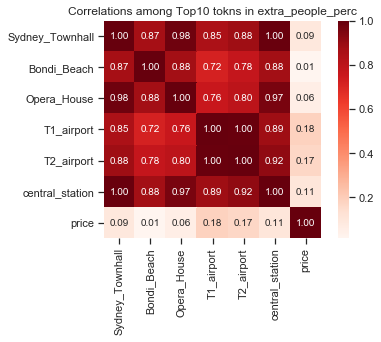

In [50]:
sns.heatmap(temp_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Correlations among Top10 tokns in '+ col)
plt.show()

In [51]:
df[location_cols]

,host_location,host_neighbourhood,street,neighbourhood,neighbourhood_cleansed,city,smart_location,latitude,longitude
0,"Cheltenham, New South Wales, Australia",None,"Beecroft, NSW, Australia",None,Hornsby,Beecroft,"Beecroft, Australia",-33.74843,151.06609
1,"New South Wales, Australia",None,"Dee Why, NSW, Australia",None,Warringah,Dee Why,"Dee Why, Australia",-33.75546,151.29509
2,AU,Camperdown,"Camperdown, NSW, Australia",Camperdown,Marrickville,Camperdown,"Camperdown, Australia",-33.89182,151.17723
3,"Sydney, New South Wales, Australia",Summer Hill,"Summer Hill, NSW, Australia",Summer Hill,Ashfield,Summer Hill,"Summer Hill, Australia",-33.89516,151.13671
4,AU,Kensington,"Kensington, NSW, Australia",Kensington,Randwick,Kensington,"Kensington, Australia",-33.90404,151.22385
5,"New South Wales, Australia",Haymarket,"Sydney, NSW, Australia",Central Business District,Sydney,Sydney,"Sydney, Australia",-33.86783,151.20329
6,Australia,Darlinghurst,"Darlinghurst, NSW, Australia",Darlinghurst,Sydney,Darlinghurst,"Darlinghurst, Australia",-33.87787,151.22101
7,"Hong Kong, Hong Kong",Chippendale,"Chippendale, NSW, Australia",Darlington,Sydney,Chippendale,"Chippendale, Australia",-33.88814,151.19540
8,"Sydney, New South Wales, Australia",None,"Bondi Beach, NSW, Australia",Tamarama,Waverley,Bondi Beach,"Bondi Beach, Australia",-33.89922,151.27382
9,"Northern Beaches of Sydney, New South Wales",None,"Dee Why, NSW, Australia",None,Warringah,Dee Why,"Dee Why, Australia",-33.75598,151.29030


##### Draw Crime rate map

Select "neighbourhood_cleansed" column

In [52]:
df["neighbourhood_cleansed"].unique()

array(['Hornsby', 'Warringah', 'Marrickville', 'Ashfield', 'Randwick',
       'Sydney', 'Waverley', 'Botany Bay', 'Manly', 'North Sydney',
       'Ryde', 'Leichhardt', 'Sutherland Shire', 'Mosman',
       'City Of Kogarah', 'Pittwater', 'Woollahra', 'Lane Cove',
       'Parramatta', 'Rockdale', 'Hunters Hill', 'Willoughby', 'Penrith',
       'Canada Bay', 'Fairfield', 'Burwood', 'Auburn', 'The Hills Shire',
       'Canterbury', 'Ku-Ring-Gai', 'Campbelltown', 'Strathfield',
       'Bankstown', 'Blacktown', 'Camden', 'Hurstville', 'Holroyd',
       'Liverpool'], dtype=object)

Rate per 100,000 population: 

source: http://crimetool.bocsar.nsw.gov.au/bocsar/

In [53]:
crime_rate = {
    'Hornsby': 390.8,
    'Warringah':239.3,
    'Marrickville':406.4,
    'Ashfield': 294.9,
    'Randwick':470.5,
    'Sydney':4970.8,
    'Waverley':375.5,
    'Botany Bay':307.8,
    'Manly':978.9,
    'North Sydney':487.7,
    'Ryde': 238.2,
    'Leichhardt':263.0,
    'Sutherland Shire':247.4,
    'Mosman':117.8,
    'City Of Kogarah':417.0,
    'Pittwater':91.3,
    'Woollahra':177.8,
    'Lane Cove':195.1,
    'Parramatta':1079.3,
    'Rockdale':331.9,
    'Hunters Hill':307.8,
    'Willoughby':130.0,
    'Penrith':2129.0,
    'Canada Bay': 146.6,
    'Fairfield':657.4,
    'Burwood':377.6,
    'Auburn':439.0,
    'The Hills Shire':146.6,
    'Canterbury':162.8,
    'Ku-Ring-Gai':87.6,
    'Campbelltown':1247.1,
    'Strathfield':244.1,
    'Bankstown':577.8,
    'Blacktown':782.0,
    'Camden':478.0,
    'Hurstville':342.1,
    'Holroyd':0.1,
    'Liverpool':1008.2,
}

neighbour_location = {
    'Hornsby': [-33.703226, 151.098387],
    'Warringah':239.3,
    'Marrickville':406.4,
    'Ashfield': 294.9,
    'Randwick':470.5,
    'Sydney':4970.8,
    'Waverley':375.5,
    'Botany Bay':307.8,
    'Manly':978.9,
    'North Sydney':487.7,
    'Ryde': 238.2,
    'Leichhardt':263.0,
    'Sutherland Shire':247.4,
    'Mosman':117.8,
    'City Of Kogarah':417.0,
    'Pittwater':91.3,
    'Woollahra':177.8,
    'Lane Cove':195.1,
    'Parramatta':1079.3,
    'Rockdale':331.9,
    'Hunters Hill':307.8,
    'Willoughby':130.0,
    'Penrith':2129.0,
    'Canada Bay': 146.6,
    'Fairfield':657.4,
    'Burwood':377.6,
    'Auburn':439.0,
    'The Hills Shire':146.6,
    'Canterbury':162.8,
    'Ku-Ring-Gai':87.6,
    'Campbelltown':1247.1,
    'Strathfield':244.1,
    'Bankstown':577.8,
    'Blacktown':782.0,
    'Camden':478.0,
    'Hurstville':342.1,
    'Holroyd':0.1,
    'Liverpool':1008.2,
}


In [54]:
# san_map = folium.Map(location = markers["Sydney_Townhall"], zoom_start = 12)

# # instantiate a mark cluster object for the incidents in the dataframe
# incidents = plugins.MarkerCluster().add_to(san_map)

# # loop through the dataframe and add each data point to the mark cluster
# for lat, lng, label, in zip(data.Y, data.X, cdata.Category):
#     folium.Marker(
#         location=[lat, lng],
#         icon=None,
#         popup=label,
#     ).add_to(incidents)

# # add incidents to map
# san_map.add_child(incidents)



In [55]:
abs(pd.concat([pd.get_dummies(df["neighbourhood_cleansed"]), df["price"]],axis=1).corr())["price"].sort_values(ascending = False)[:10]

price           1.000000
Pittwater       0.181261
Mosman          0.096733
Sydney          0.083544
Manly           0.080161
Warringah       0.074949
Marrickville    0.068635
Waverley        0.053905
Botany Bay      0.049641
Rockdale        0.044322
Name: price, dtype: float64

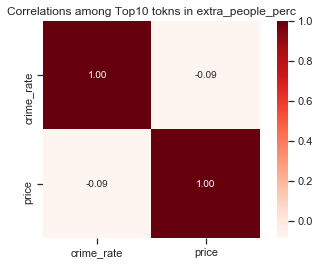

In [56]:
crime = pd.DataFrame([crime_rate[x] for x in df["neighbourhood_cleansed"]],columns=["crime_rate"])
temp_df = pd.concat([crime, df["price"]],axis=1)

sns.heatmap(temp_df.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Correlations among Top10 tokns in '+ col)
plt.show()

### Numerical columns

In [57]:
boxcox = PowerTransformer(method='box-cox')
yeoj = PowerTransformer(method='yeo-johnson')
dict_Power_method = {}

# def eda_continue(df_continue):
#     print(get_status(df_continue))
#     plot_dists(df_continue) 
    

    

def creat_powerTransformer_df(df, cols, dict_Power_method):
    trans = pd.DataFrame()
    for col in cols:
        if dict_Power_method[col] == 0:
            trans[col] = boxcox.fit_transform(pd.DataFrame(df[col])).flatten()
        elif dict_Power_method[col] == 1:
            trans[col] = yeoj.fit_transform(pd.DataFrame(df[col])).flatten()
    return trans

#### review_scores_cols

In [58]:
review_scores_cols

['review_scores_rating',
 'review_scores_accuracy',
 'review_scores_cleanliness',
 'review_scores_checkin',
 'review_scores_communication',
 'review_scores_location',
 'review_scores_value']

In [59]:
accumulation = df["review_scores_accuracy"] + df["review_scores_cleanliness"] + df["review_scores_checkin"] + \
    df["review_scores_communication"] + \
    df["review_scores_location"] + df["review_scores_value"]
accumulation.name = "accumulation"

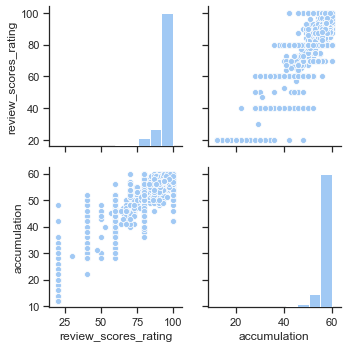

In [60]:
sns.pairplot(pd.concat([df["review_scores_rating"], accumulation],axis=1))

In [61]:
pd.concat([df["review_scores_rating"], accumulation],axis=1).corr()

,review_scores_rating,accumulation
review_scores_rating,1.000000,0.839306
accumulation,0.839306,1.000000


In [62]:
get_status(pd.DataFrame(df["review_scores_rating"]))

,review_scores_rating
count,9694.000
mean,93.620
min,20.000
25%,93.636
50%,93.636
75%,99.000
max,100.000
median,93.636
mad,4.363
var,64.023


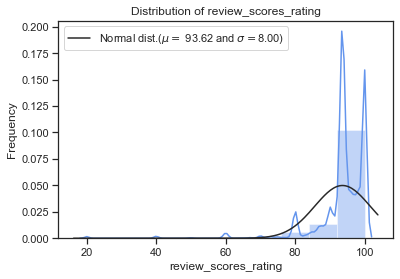

In [63]:
plot_distributed(df["review_scores_rating"])

((array([-3.80292044, -3.57733977, -3.45347467, ...,  3.45347467,
          3.57733977,  3.80292044]),
  array([ 20.,  20.,  20., ..., 100., 100., 100.])),
 (6.376208503805313, 93.61971448268227, 0.7966330388940679))

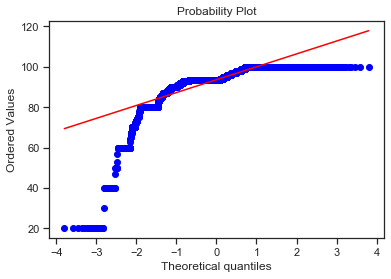

In [64]:
stats.probplot(df["review_scores_rating"],plot=plt)

In [65]:
dict_Power_method_new = {
    "review_scores_rating": 0,
}
dict_Power_method.update(dict_Power_method_new)

temp = creat_powerTransformer_df(
    df, ["review_scores_rating"], dict_Power_method)

In [66]:
get_status(pd.DataFrame(temp))

,review_scores_rating
count,9694.000
mean,0.000
min,-2.531
25%,-0.310
50%,-0.310
75%,1.012
max,1.324
median,-0.310
mad,0.809
var,1.000


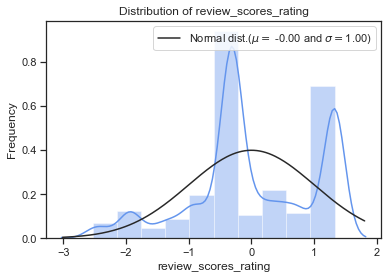

In [67]:
plot_distributed(temp["review_scores_rating"])


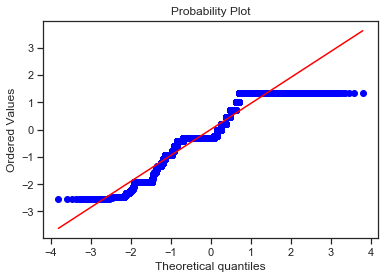

In [68]:
stats.probplot(temp["review_scores_rating"],plot=plt);

只用 review_scores_rating 就好

#### percent_cols

In [69]:
temp_df = df[percent_cols]
temp_df.head()

,security_deposit_perc,cleaning_fee_perc,extra_people_perc
0,259.0,69.0,52.0
1,160.0,68.0,8.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,20.0,0.0


In [70]:
for col in percent_cols:
    temp_df[col+"_money"] = pd.Series([df["price"][idx] * df[col][idx]/100  for idx in range(len(df))])

In [71]:
temp_df.head()

,security_deposit_perc,cleaning_fee_perc,extra_people_perc,security_deposit_perc_money,cleaning_fee_perc_money,extra_people_perc_money
0,259.0,69.0,52.0,150.22,40.02,30.16
1,160.0,68.0,8.0,200.00,85.00,10.00
2,0.0,0.0,0.0,0.00,0.00,0.00
3,0.0,0.0,0.0,0.00,0.00,0.00
4,0.0,20.0,0.0,0.00,25.00,0.00


#### numerical columns

#### time_cols

In [72]:
temp.head()

,review_scores_rating
0,-0.310169
1,-2.337472
2,-0.310169
3,-0.310169
4,1.323941


EDA

powerTransformer

corr

### Category columns

#### set_cols

In [73]:
df[set_cols].head()

,host_verifications,amenities
0,"['email', 'phone', 'reviews', 'jumio', 'offlin...","{TV,Wifi,Kitchen,Elevator,Heating,Washer,""Smok..."
1,"['email', 'phone', 'reviews', 'jumio', 'govern...","{TV,Wifi,Kitchen,""Free street parking"",""Family..."
2,"['email', 'phone']","{TV,Internet,Wifi,Kitchen,Washer,Essentials}"
3,"['email', 'phone', 'reviews', 'jumio', 'govern...","{Wifi,Kitchen,""Smoking allowed"",Heating,Washer..."
4,"['email', 'phone', 'reviews']","{TV,Wifi,Kitchen,""Suitable for events"",Washer,..."


##### Length of each column

In [74]:
def length_set_col(df,set_cols):
    length_set_cols = pd.DataFrame()
    for col in set_cols:
        temp = df[col].apply(lambda x: len(x.split(","))).rename("length_"+col)
        length_set_cols = pd.concat([length_set_cols, temp],axis=1)
    return length_set_cols

In [75]:
temp = length_set_col(df, set_cols)


In [76]:
get_status(pd.DataFrame(temp))

,length_host_verifications,length_amenities
count,9694.000,9694.000
mean,5.191,22.889
min,1.000,1.000
25%,3.000,14.000
50%,5.000,20.000
75%,7.000,30.000
max,12.000,97.000
median,5.000,20.000
mad,1.770,9.651
var,4.600,147.296


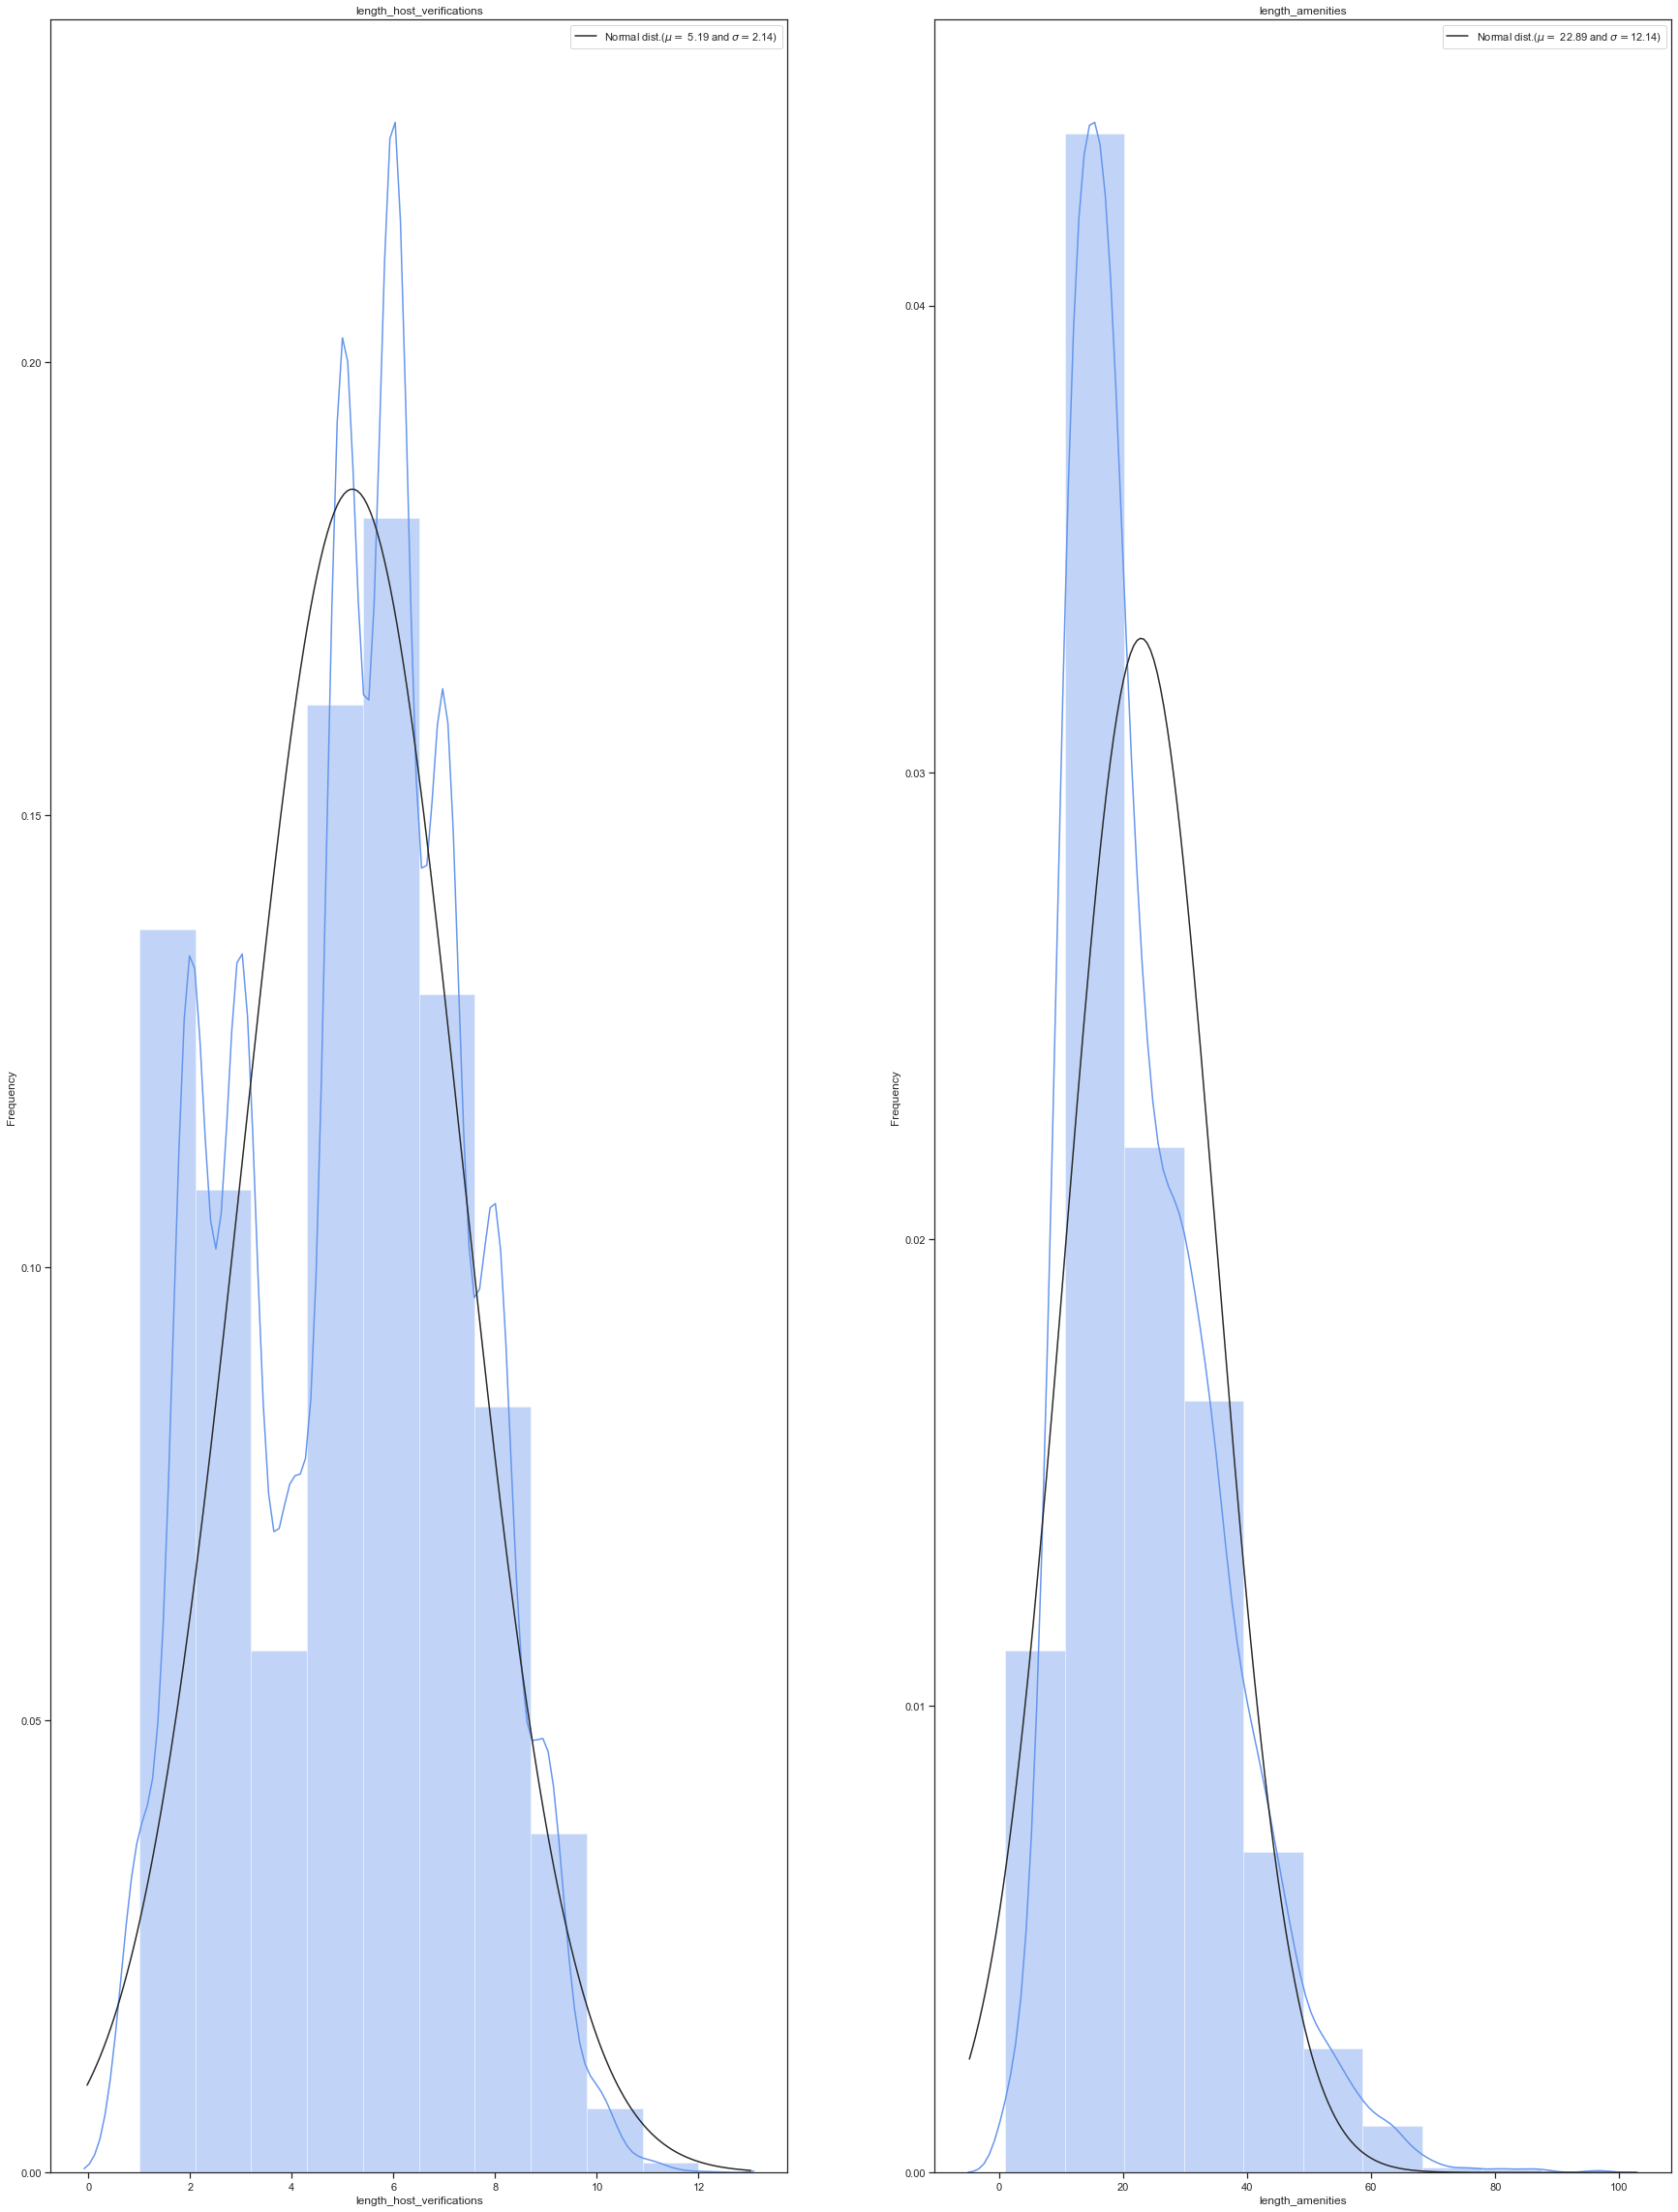

In [77]:
plot_distributed(temp["length_host_verifications"])
plot_distributed(temp["length_amenities"])

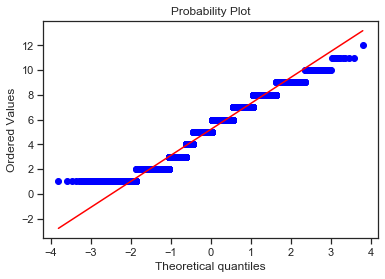

In [78]:
plot_prob(temp["length_host_verifications"])

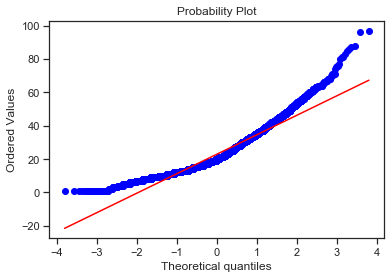

In [79]:
plot_prob(temp["length_amenities"])

In [80]:
temp = pd.concat([temp, df["price"]],axis=1)
temp.corr()


,length_host_verifications,length_amenities,price
length_host_verifications,1.000000,0.221652,0.033841
length_amenities,0.221652,1.000000,0.142742
price,0.033841,0.142742,1.000000


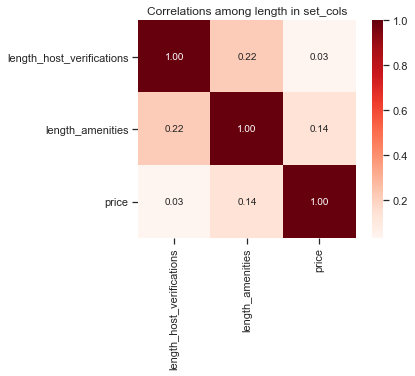

In [81]:
sns.heatmap(temp.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Correlations among length in set_cols' )
plt.show()

######  powerTransformer

In [82]:
dict_Power_method_new = {
    "length_host_verifications": 0,
    "length_amenities": 0,    
}

dict_Power_method.update(dict_Power_method_new)

In [83]:
temp = pd.concat([length_set_col(df, set_cols), df["price"]], axis=1)
temp = creat_powerTransformer_df(
    temp, ["length_host_verifications", "length_amenities"], dict_Power_method)

In [84]:
temp = pd.concat([temp, df["price"]],axis=1)
temp.corr()["price"]

length_host_verifications    0.034142
length_amenities             0.142216
price                        1.000000
Name: price, dtype: float64

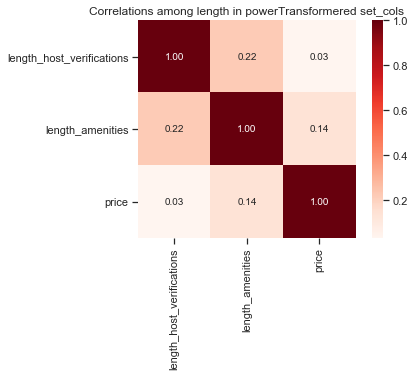

In [85]:
sns.heatmap(temp.corr(),vmax=1,square=True,annot=True,fmt=".2f",cmap="Reds")
plt.title('Correlations among length in powerTransformered set_cols' )
plt.show()

Help 

In [86]:
# def string_clean(t, strip):
#     if strip == "[]":
#         return t.strip('[]').replace("\'","").replace(" ","").split(",")
#     if strip == "{}":
#         return t.strip('{}').replace("\'","").replace(" ","").split(",")

# import itertools
# word_list = []
# for i,t in enumerate(df["host_verifications"]):
#     word_list.append(string_clean(t,"[]"))

# len(set(list(itertools.chain.from_iterable(word_list))))  
    

#####  Tokens in each columns

In [87]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df["host_verifications"])

In [88]:
vectorizer.get_feature_names()

['email',
 'facebook',
 'google',
 'government_id',
 'identity_manual',
 'jumio',
 'kba',
 'manual_offline',
 'manual_online',
 'offline_government_id',
 'phone',
 'photographer',
 'reviews',
 'selfie',
 'sent_id',
 'sesame',
 'sesame_offline',
 'weibo',
 'work_email',
 'zhima_selfie']

In [89]:
X.toarray()

array([[1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 1, 0],
       [1, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [90]:
process_text(df["host_verifications"],df["price"]).head()

,host_verifications_token_manual_online,host_verifications_token_work_email,host_verifications_token_government_id,host_verifications_token_reviews,host_verifications_token_facebook,host_verifications_token_jumio,host_verifications_token_sesame,host_verifications_token_sesame_offline,host_verifications_token_manual_offline,host_verifications_token_zhima_selfie
0,0,0,1,1,0,1,0,0,0,0
1,0,1,1,1,0,1,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0


   host_verifications_token_manual_online  \
0                                       0   
1                                       0   
2                                       0   
3                                       0   
4                                       0   

   host_verifications_token_work_email  \
0                                    0   
1                                    1   
2                                    0   
3                                    0   
4                                    0   

   host_verifications_token_government_id  host_verifications_token_reviews  \
0                                       1                                 1   
1                                       1                                 1   
2                                       0                                 0   
3                                       1                                 1   
4                                       0                                 1   

 

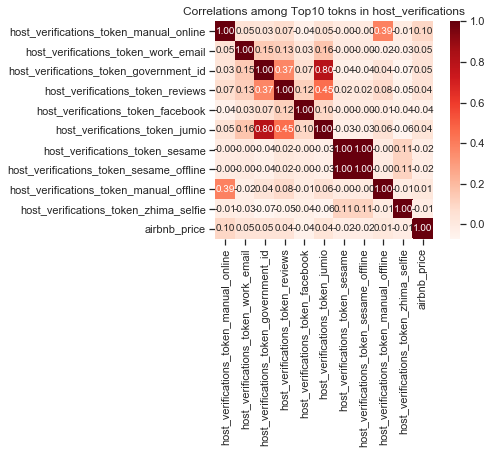

   amenities_token_kid  amenities_token_family  amenities_token_fireplace  \
0                    0                       0                          0   
1                    1                       1                          0   
2                    0                       0                          0   
3                    0                       0                          0   
4                    0                       0                          0   

   amenities_token_indoor  amenities_token_friendly  amenities_token_toys  \
0                       0                         1                     0   
1                       0                         2                     0   
2                       0                         0                     0   
3                       0                         0                     0   
4                       0                         0                     0   

   amenities_token_books  amenities_token_children  amenities_token_cable 

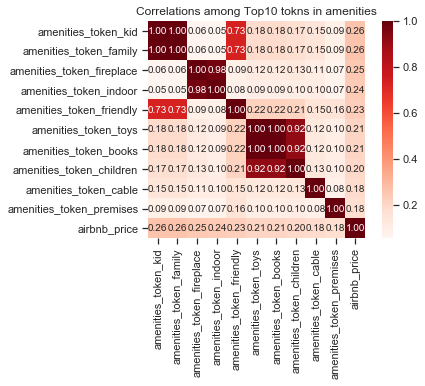

In [91]:
txt_eda(df, set_cols,response)

In [92]:
fe_text(df, set_cols, response).head()

,host_verifications_token_manual_online,host_verifications_token_work_email,host_verifications_token_government_id,host_verifications_token_reviews,host_verifications_token_facebook,host_verifications_token_jumio,host_verifications_token_sesame,host_verifications_token_sesame_offline,host_verifications_token_manual_offline,host_verifications_token_zhima_selfie,amenities_token_kid,amenities_token_family,amenities_token_fireplace,amenities_token_indoor,amenities_token_friendly,amenities_token_toys,amenities_token_books,amenities_token_children,amenities_token_cable,amenities_token_premises
0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,0,1,1,1,0,1,0,0,0,0,1,1,0,0,2,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### category_cols

In [93]:
def dummy_cols(df, cols):
    d = pd.DataFrame()
    for col in cols:
        dummies = pd.get_dummies(
            df[col], prefix_sep="_", drop_first=True, prefix=col)
        #df.drop(columns=col, inplace=True)
        d = pd.concat([d, dummies], axis=1)

    return d

In [94]:
df[category_cols]

,experiences_offered,host_response_time,is_location_exact,property_type,room_type,cancellation_policy,host_is_superhost,host_identity_verified,requires_license,instant_bookable,is_business_travel_ready,require_guest_profile_picture,require_guest_phone_verification,bed_type
0,none,within an hour,f,Apartment,Private room,moderate,f,t,f,f,f,f,f,Real Bed
1,none,within a day,t,Apartment,Entire home/apt,strict_14_with_grace_period,f,t,f,f,f,f,f,Real Bed
2,none,None,t,House,Private room,flexible,f,f,f,f,f,f,f,Real Bed
3,none,None,t,House,Private room,strict_14_with_grace_period,f,t,f,f,f,f,f,Real Bed
4,none,None,t,Apartment,Entire home/apt,flexible,f,f,f,t,f,f,f,Real Bed
5,none,within an hour,t,Apartment,Entire home/apt,strict_14_with_grace_period,t,t,f,t,f,f,f,Real Bed
6,none,within an hour,t,Townhouse,Entire home/apt,flexible,f,f,f,f,f,f,f,Real Bed
7,none,within a day,t,Apartment,Entire home/apt,strict_14_with_grace_period,f,f,f,f,f,f,f,Real Bed
8,none,within a few hours,f,Apartment,Entire home/apt,moderate,f,f,f,f,f,f,f,Real Bed
9,none,within an hour,f,Apartment,Entire home/apt,moderate,f,t,f,t,f,f,f,Real Bed


In [95]:
for col in category_cols:
    print(pd.crosstab(index=df[col], columns="count"))


col_0                count
experiences_offered       
none                  9694
col_0               count
host_response_time       
None                 4522
a few days or more    164
within a day          699
within a few hours    857
within an hour       3452
col_0              count
is_location_exact       
f                   2415
t                   7279
col_0               count
property_type            
Aparthotel              4
Apartment            5982
Barn                    1
Bed and breakfast      54
Boat                    6
Boutique hotel         46
Bungalow               50
Cabin                  15
Camper/RV               3
Cave                    1
Condominium           178
Cottage                30
Dome house              1
Farm stay               5
Guest suite           153
Guesthouse            109
Hostel                 23
Hotel                   8
House                2372
Loft                   62
Other                  25
Serviced apartment     74
Tent         

Encode smaller number of categorical variables for property type

property_type cancellation_policy bed_type 

Remove column contain only one category:

experiences_offered requires_license is_business_travel_ready

In [138]:
for col in ["experiences_offered", "requires_license", "is_business_travel_ready"]:
    category_cols.remove(col)

In [139]:
df_temp = df[category_cols]

In [96]:
pd.crosstab(index=df["cancellation_policy"], columns="count")

col_0,count
cancellation_policy,
None,1
flexible,3246
moderate,2270
strict_14_with_grace_period,4131
super_strict_30,20
super_strict_60,26


In [141]:
temp = np.where(df['cancellation_policy'].str.contains('None'), "None",
                (np.where(df['cancellation_policy'].str.contains('flexible'), "flexible",
                          (np.where(df['cancellation_policy'].str.contains('moderate'), "moderate", "strict")))))
df_temp["cancellation_policy"] = temp

pd.crosstab(index=temp, columns="count")

col_0,count
row_0,
None,1
flexible,3246
moderate,2270
strict,4177


In [97]:
pd.crosstab(index=df["bed_type"], columns="count")


col_0,count
bed_type,
Airbed,4
Couch,1
Futon,12
Pull-out Sofa,29
Real Bed,9648


In [142]:
temp = np.where(df['bed_type'].str.contains('Real Bed'), "Real Bed", "Other")
df_temp["bed_type"] = temp
pd.crosstab(index=temp, columns="count")

col_0,count
row_0,
Other,46
Real Bed,9648


In [99]:
pd.crosstab(index=df["property_type"], columns="count")


col_0,count
property_type,
Aparthotel,4
Apartment,5982
Barn,1
Bed and breakfast,54
Boat,6
Boutique hotel,46
Bungalow,50
Cabin,15
Camper/RV,3


In [143]:
temp = np.where(df['property_type'].str.contains('House'), "House", (np.where(df['property_type'].str.contains('Apartment'), "Apartment", (np.where(df['property_type'].str.contains('Townhouse'), "Townhouse", "Other")))))
df_temp["property_type"] = temp
pd.crosstab(index=temp, columns="count")

col_0,count
row_0,
Apartment,5982
House,2372
Other,919
Townhouse,421


In [144]:
df_temp["price"] = df["price"]

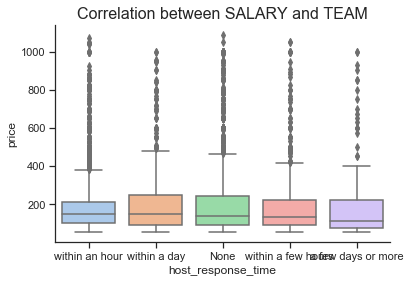

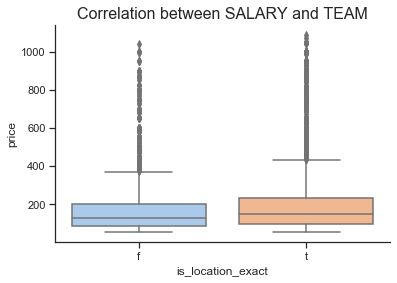

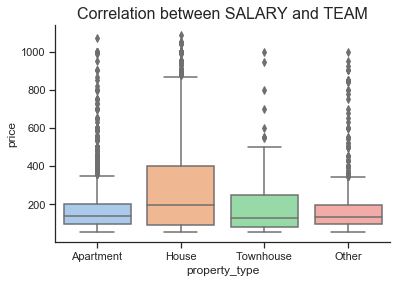

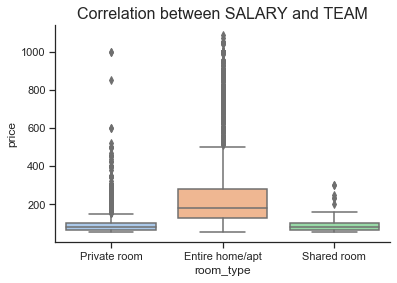

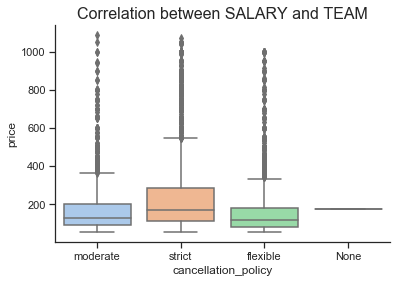

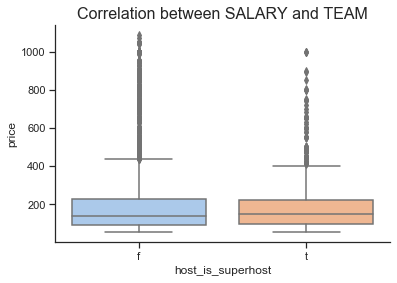

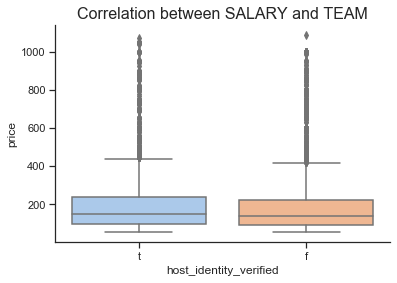

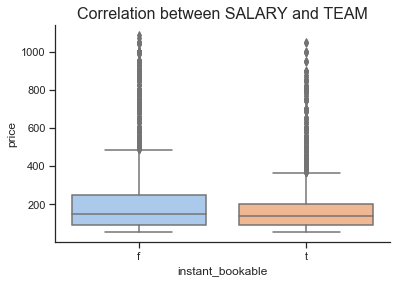

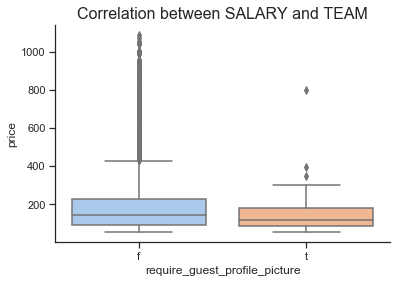

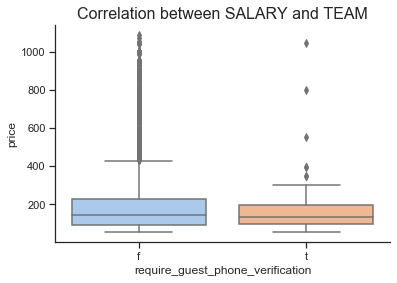

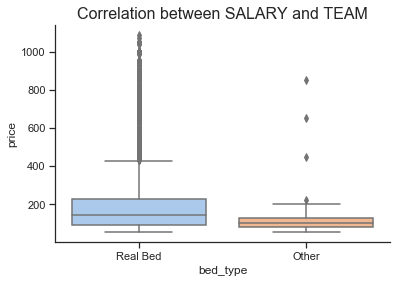

In [145]:
for col in category_cols:
    plt.figure()
    sns.set_palette("pastel")
    sns.boxplot(x = col, y = 'price', data = df_temp)
    sns.despine()
    plt.title('Correlation between SALARY and TEAM', fontsize = 16)
    plt.show()

In [146]:
temp = pd.concat([dummy_cols(df_temp, category_cols),df["price"]], axis=1)
temp.head()

,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,is_location_exact_t,property_type_House,property_type_Other,property_type_Townhouse,room_type_Private room,room_type_Shared room,cancellation_policy_flexible,cancellation_policy_moderate,cancellation_policy_strict,host_is_superhost_t,host_identity_verified_t,instant_bookable_t,require_guest_profile_picture_t,require_guest_phone_verification_t,bed_type_Real Bed,price
0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,0,1,58.0
1,0,1,0,0,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,125.0
2,0,0,0,0,1,1,0,0,1,0,1,0,0,0,0,0,0,0,1,99.0
3,0,0,0,0,1,1,0,0,1,0,0,0,1,0,1,0,0,0,1,99.0
4,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,1,125.0


In [147]:
print(abs(temp.corr()["price"]).sort_values(ascending=False))

price                                    1.000000
room_type_Private room                   0.398519
property_type_House                      0.307306
cancellation_policy_strict               0.209857
cancellation_policy_flexible             0.140557
cancellation_policy_moderate             0.088734
instant_bookable_t                       0.075167
property_type_Other                      0.045002
is_location_exact_t                      0.043183
room_type_Shared room                    0.040971
host_response_time_within an hour        0.027443
host_is_superhost_t                      0.027276
host_response_time_within a day          0.023759
bed_type_Real Bed                        0.020367
property_type_Townhouse                  0.019188
require_guest_profile_picture_t          0.019159
host_identity_verified_t                 0.016741
host_response_time_a few days or more    0.005557
host_response_time_within a few hours    0.002799
require_guest_phone_verification_t       0.002645


Text(0.5, 1, 'Correlation Among Variables')

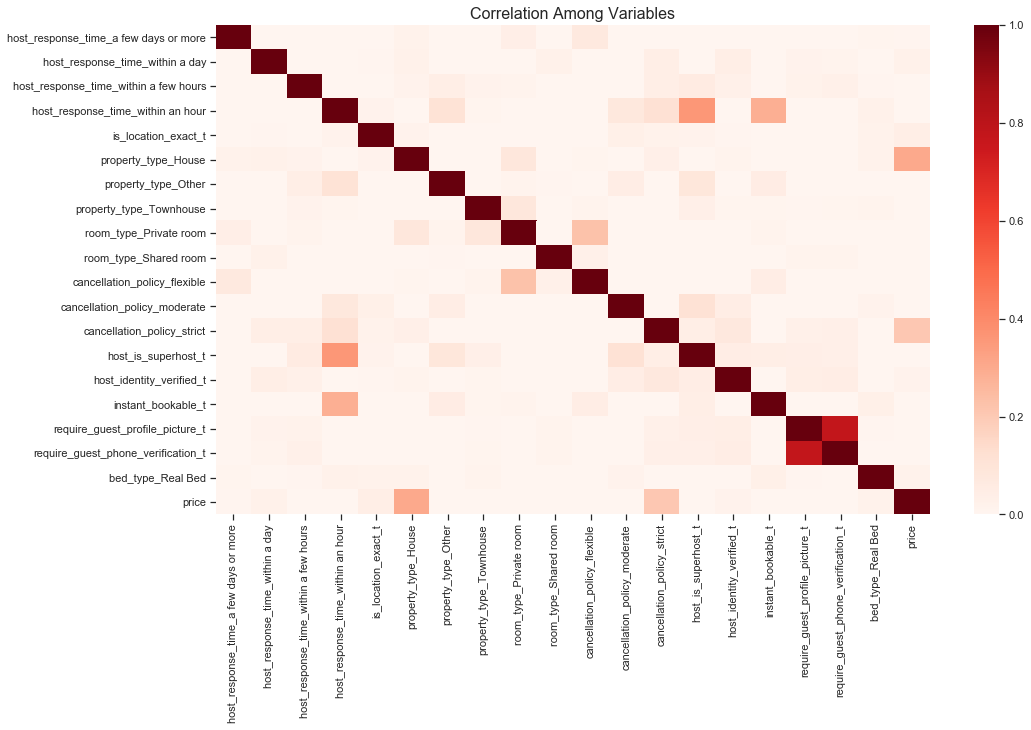

In [148]:
plt.figure(figsize=(16, 9))
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Reds')
plt.title('Correlation Among Variables', fontsize=16)

In [149]:
temp.corr()["require_guest_phone_verification_t"]["require_guest_profile_picture_t"]

0.7787030656604769

## Feature Engineering


### txt columns

### location cols

In [ ]:
temp = [haversine(df["longitude"][idx], df["latitude"][idx], markers["T1_airport"][1], 
           markers["T1_airport"][0]) for idx in range(len(df))]

## Modelling

## Summit